In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.data import TimeSeriesDataSet, GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss

import re
import sys

/miniconda3/envs/gnns/lib/python3.13/site-packages/pytorch_forecasting/models/base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
torch.set_float32_matmul_precision('medium')

# Data Loading and Preprocessing

Load the air quality dataset and perform initial preprocessing.

In [4]:
# Define paths
data_path = "/code/GCNTFT/data/processed/before_gnn.csv"
# Load the air quality data
air_quality_df = pd.read_csv(data_path)
air_quality_df['datetime'] = pd.to_datetime(air_quality_df['datetime'])
air_quality_df.head(5)

,datetime,PM25,Ozone,city,station_loc,CO,NOx,hour,dayofmonth,dayofweek,...,PM25_lag_1h,PM25_lag_3h,PM25_lag_6h,PM25_lag_12h,PM25_lag_24h,PM25_diff_1,PM25_diff_24,PM25_rolling_mean_3,PM25_rolling_mean_6,PM25_rolling_mean_24
0,2020-11-13 14:00:00,85.0,171.55,Delhi,Ashok Vihar,0.50,24.5,14,13,4,...,104.5,184.0,300.0,283.0,72.5,-19.5,12.5,114.500000,187.916667,227.854167
1,2020-11-13 15:00:00,83.0,147.80,Delhi,Ashok Vihar,0.87,24.5,15,13,4,...,85.0,154.0,300.0,300.0,80.5,-2.0,2.5,90.833333,151.750000,227.958333
2,2020-11-13 16:00:00,90.0,102.57,Delhi,Ashok Vihar,1.20,24.5,16,13,4,...,83.0,104.5,300.0,300.0,88.0,7.0,2.0,86.000000,116.750000,228.041667
3,2020-11-13 17:00:00,105.0,33.45,Delhi,Ashok Vihar,1.70,24.5,17,13,4,...,90.0,85.0,184.0,300.0,108.5,15.0,-3.5,92.666667,103.583333,227.895833
4,2020-11-13 18:00:00,163.0,8.50,Delhi,Ashok Vihar,2.43,129.2,18,13,4,...,105.0,83.0,154.0,300.0,129.0,58.0,34.0,119.333333,105.083333,229.312500


In [5]:
air_quality_df.columns

Index(['datetime', 'PM25', 'Ozone', 'city', 'station_loc', 'CO', 'NOx', 'hour',
       'dayofmonth', 'dayofweek', 'dayofyear', 'weekofyear', 'month',
       'quarter', 'year', 'pm_lag_1Y', 'latitude', 'longitude', 'time_idx',
       'group_id', 'station_hour_sin', 'station_hour_cos', 'PM25_lag_1h',
       'PM25_lag_3h', 'PM25_lag_6h', 'PM25_lag_12h', 'PM25_lag_24h',
       'PM25_diff_1', 'PM25_diff_24', 'PM25_rolling_mean_3',
       'PM25_rolling_mean_6', 'PM25_rolling_mean_24'],
      dtype='object')

In [6]:
air_quality_df.shape

(208420, 32)

In [7]:
air_quality_df.station_loc.value_counts()

station_loc
Ashok Vihar        20842
Aya Nagar          20842
Burari Crossing    20842
Chandni Chowk      20842
Jahangirpuri       20842
NSIT Dwarka        20842
Najafgarh          20842
North Campus       20842
Shadipur           20842
Vivek Vihar        20842
Name: count, dtype: int64

In [ ]:
# Get list of unique stations
stations = air_quality_df['station_loc'].unique()
latest_data = []

for station in stations:
    station_data = air_quality_df[air_quality_df['station_loc'] == station]
    station_data = station_data.sort_values('datetime', ascending=False)
    station_data = station_data.head(10000)
    latest_data.append(station_data)

reduced_df = pd.concat(latest_data)
reduced_df = reduced_df.sort_values('datetime')
reduced_df = reduced_df.reset_index(drop=True)

print(f"Original dataframe shape: {air_quality_df.shape}")
print(f"Reduced dataframe shape: {reduced_df.shape}")

air_quality_df = reduced_df

Original dataframe shape: (208420, 32)
Reduced dataframe shape: (100000, 32)


In [9]:
air_quality_df.datetime.min(), air_quality_df.datetime.max()

(Timestamp('2022-02-08 08:00:00'), Timestamp('2023-03-31 23:00:00'))

# Load Embedding Data

Load station embeddings that can enhance the PM2.5 forecasting model.

In [10]:
embeddings_path = "/code/GCNTFT/data/embeddings_v2_final_202504061203/tft_ready_embeddings.csv"
embeddings_df = pd.read_csv(embeddings_path)
embeddings_df['datetime'] = pd.to_datetime(embeddings_df['datetime'])

In [11]:
embeddings_df.head(2)

,datetime,station_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,...,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31
0,2020-11-14 13:00:00,Ashok Vihar,0.005800,-0.041713,-0.009483,0.006030,0.003884,-0.004093,0.005083,0.002411,...,-0.058154,0.002203,-0.048979,0.006229,0.016343,-0.016213,0.032106,-0.019386,0.002972,-0.005489
1,2020-11-14 13:00:00,Aya Nagar,-0.001527,-0.134443,-0.005833,0.087024,0.028356,0.011187,-0.010544,0.002566,...,-0.011935,-0.048958,0.007990,-0.030577,-0.007792,-0.009733,0.038728,-0.009127,-0.018038,0.015324


In [12]:
embedding_col_names = embeddings_df.columns[2:].to_list()
embedding_col_names[:4]

['emb_0', 'emb_1', 'emb_2', 'emb_3']

In [ ]:

# embedding_cols = {str(i): f'embedding_{i+1}' for i in range(32)}
# embeddings_df = embeddings_df.rename(columns=embedding_cols)
embeddings_df = embeddings_df.rename(columns={'station_id': 'station_loc'})
embeddings_df = embeddings_df.reset_index(drop=True)
embeddings_df.head(2)

,datetime,station_loc,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,...,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31
0,2020-11-14 13:00:00,Ashok Vihar,0.005800,-0.041713,-0.009483,0.006030,0.003884,-0.004093,0.005083,0.002411,...,-0.058154,0.002203,-0.048979,0.006229,0.016343,-0.016213,0.032106,-0.019386,0.002972,-0.005489
1,2020-11-14 13:00:00,Aya Nagar,-0.001527,-0.134443,-0.005833,0.087024,0.028356,0.011187,-0.010544,0.002566,...,-0.011935,-0.048958,0.007990,-0.030577,-0.007792,-0.009733,0.038728,-0.009127,-0.018038,0.015324


In [14]:
embeddings_df.shape

(208190, 34)

# Merge Air Quality Data with Embeddings

Join the air quality data with the embeddings to enhance the forecasting model.

In [ ]:
# Merge air_quality_df with embeddings
merged_df = air_quality_df.merge(
    embeddings_df, 
    on=['datetime', 'station_loc'], 
    how='left'
)

# nan_count = merged_df['embedding_1'].isna().sum()
# print(f"Number of rows with missing embeddings: {nan_count} out of {len(merged_df)}")

print(f"Original dataframe shape: {air_quality_df.shape}")
print(f"Dataframe with embeddings shape: {merged_df.shape}")

# Drop rows with missing embeddings
air_quality_df = merged_df.dropna()
print(f"Dataframe with embeddings shape after dropna: {air_quality_df.shape}")

air_quality_df.head(2)

Original dataframe shape: (100000, 32)
Dataframe with embeddings shape: (100000, 64)
Dataframe with embeddings shape after dropna: (100000, 64)


,datetime,PM25,Ozone,city,station_loc,CO,NOx,hour,dayofmonth,dayofweek,...,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31
0,2022-02-08 08:00:00,282.25,70.05,Delhi,Jahangirpuri,2.72,153.07,8,8,1,...,-0.006627,-0.004893,0.005746,-0.018051,-0.016904,-0.005203,0.016031,-0.000605,-0.005016,0.005215
1,2022-02-08 08:00:00,94.48,11.39,Delhi,Shadipur,1.53,92.59,8,8,1,...,-0.010381,-0.001186,-0.004531,-0.008575,-0.012670,-0.003756,0.012594,-0.003060,-0.000736,0.002948


In [16]:
from lightning.pytorch.loggers import MLFlowLogger

mlf_logger = MLFlowLogger(experiment_name="gcntft_final", tracking_uri="file:./../mlflow_experiments")

# Prepare TFT Model Configuration

Set up parameters for the Temporal Fusion Transformer model.

In [ ]:
# Define max_prediction_length and max_encoder_length
max_prediction_length = 24  # predict 24 hours ahead
max_encoder_length = 72  # 3 days worth

# Create a training cutoff
training_cutoff = air_quality_df["time_idx"].max() - max_prediction_length * 2

# Feature Selection

Select which features to use for the TFT model.

In [18]:
# Time-related features that are known in advance
time_varying_known_reals = ['hour', 'dayofmonth', 'dayofweek', 'dayofyear',
                            'weekofyear', 'month', 'quarter', 'year',
                            'station_hour_sin','station_hour_cos']

In [19]:
# Target variable and related features
time_varying_unknown_reals = [ 
    'PM25',
    'PM25_diff_24',
    'PM25_rolling_mean_24'
] + embedding_col_names

In [20]:
final_features = list(set([
    "time_idx", "latitude", "longitude", "PM25",
"station_loc" , 
]
+ time_varying_known_reals + time_varying_unknown_reals))

In [21]:
len(final_features)

49

In [ ]:
#final filter before training

air_quality_df = air_quality_df[final_features]

# Create TimeSeriesDataset

Set up the training and validation datasets for the TFT model.

In [23]:
# Create the training dataset
training = TimeSeriesDataSet(
    data=air_quality_df[air_quality_df["time_idx"] <= training_cutoff],
    time_idx="time_idx",
    target="PM25",
    group_ids=["station_loc"],
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["station_loc"],
    static_reals=["latitude", "longitude"],
    time_varying_known_categoricals=[],
    time_varying_known_reals=time_varying_known_reals,
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=time_varying_unknown_reals,
    target_normalizer=GroupNormalizer(
        groups=["station_loc"]
    ),
    lags={
        "PM25": [48, 72], #, 96, 120, 144, 168
    },
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [24]:
# Create the validation dataset
validation = TimeSeriesDataSet.from_dataset(
    training, 
    air_quality_df, 
    min_prediction_idx=training_cutoff + 1,
    predict=True,
    stop_randomization=True,
)

In [25]:
# Create data loaders
batch_size = 64

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=8, shuffle=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=8)

# Define TFT Model

Create and configure the Temporal Fusion Transformer model.

In [ ]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.005,
    hidden_size=128,        
    attention_head_size=2,  
    dropout=0.1,           
    hidden_continuous_size=32,  
    optimizer="ranger",   
    loss=QuantileLoss(),
    reduce_on_plateau_patience=4,
)

/miniconda3/envs/gnns/lib/python3.13/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/miniconda3/envs/gnns/lib/python3.13/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [27]:
# Create PyTorch Lightning callbacks
early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    min_delta=1e-4, 
    patience=5,
    verbose=True, 
    mode="min"
)

# Add learning rate monitors
lr_monitor = LearningRateMonitor(logging_interval="epoch")

In [28]:
# Set up trainer
trainer = pl.Trainer(
    max_epochs=20,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    gradient_clip_val=0.1,  # Added gradient clipping for stability
    callbacks=[early_stop_callback, lr_monitor],
    logger=mlf_logger,
    log_every_n_steps=10
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


# Find Optimal Learning Rate

Use the learning rate finder to determine the optimal learning rate.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Finding best initial lr: 100%|██████████| 100/100 [01:02<00:00,  1.60it/s]
Learning rate set to 0.0005011872336272723
Restoring states from the checkpoint path at /code/GCNTFT/tft_src/.lr_find_04955eb7-22d9-4619-b28a-649b6869ae6c.ckpt
Restored all states from the checkpoint at /code/GCNTFT/tft_src/.lr_find_04955eb7-22d9-4619-b28a-649b6869ae6c.ckpt


suggested learning rate: 0.0005011872336272723


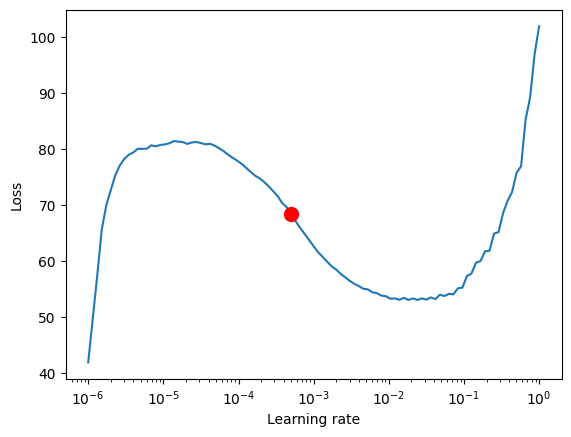

/tmp/ipykernel_217943/3596754805.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [29]:
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=1.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [30]:
# Update learning rate based on the suggestion
suggested_lr = res.suggestion()
print(f"Updating learning rate to: {suggested_lr}")
tft.hparams.learning_rate = suggested_lr

Updating learning rate to: 0.0005011872336272723


# Train the TFT Model

Train the Temporal Fusion Transformer model for PM2.5 forecasting.

In [31]:
# Train the model
trainer.fit(
    tft, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 60     | train
3  | prescalers                         | ModuleDict                      | 3.4 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 57.9 K | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 627 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 129 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 66.3 K | train
8  | static_context_initial_hidden_lstm |

Epoch 0: 100%|██████████| 1528/1528 [17:00<00:00,  1.50it/s, v_num=25cb, train_loss_step=21.70, val_loss=24.90, train_loss_epoch=27.40]

Metric val_loss improved. New best score: 24.899


Epoch 1: 100%|██████████| 1528/1528 [17:07<00:00,  1.49it/s, v_num=25cb, train_loss_step=17.60, val_loss=24.70, train_loss_epoch=20.30]

Metric val_loss improved by 0.186 >= min_delta = 0.0001. New best score: 24.713


Epoch 2: 100%|██████████| 1528/1528 [17:02<00:00,  1.49it/s, v_num=25cb, train_loss_step=19.60, val_loss=20.90, train_loss_epoch=19.40]

Metric val_loss improved by 3.821 >= min_delta = 0.0001. New best score: 20.891


Epoch 3: 100%|██████████| 1528/1528 [17:18<00:00,  1.47it/s, v_num=25cb, train_loss_step=19.10, val_loss=19.30, train_loss_epoch=18.90]

Metric val_loss improved by 1.632 >= min_delta = 0.0001. New best score: 19.259


Epoch 4: 100%|██████████| 1528/1528 [17:15<00:00,  1.48it/s, v_num=25cb, train_loss_step=16.40, val_loss=16.80, train_loss_epoch=18.40]

Metric val_loss improved by 2.440 >= min_delta = 0.0001. New best score: 16.819


Epoch 6: 100%|██████████| 1528/1528 [17:19<00:00,  1.47it/s, v_num=25cb, train_loss_step=14.90, val_loss=14.80, train_loss_epoch=17.60]

Metric val_loss improved by 2.004 >= min_delta = 0.0001. New best score: 14.815


Epoch 7: 100%|██████████| 1528/1528 [17:10<00:00,  1.48it/s, v_num=25cb, train_loss_step=16.30, val_loss=13.70, train_loss_epoch=17.30]

Metric val_loss improved by 1.112 >= min_delta = 0.0001. New best score: 13.703


Epoch 8: 100%|██████████| 1528/1528 [17:08<00:00,  1.49it/s, v_num=25cb, train_loss_step=15.50, val_loss=13.20, train_loss_epoch=17.10]

Metric val_loss improved by 0.517 >= min_delta = 0.0001. New best score: 13.186


Epoch 9: 100%|██████████| 1528/1528 [17:17<00:00,  1.47it/s, v_num=25cb, train_loss_step=16.90, val_loss=12.80, train_loss_epoch=16.90]

Metric val_loss improved by 0.393 >= min_delta = 0.0001. New best score: 12.793


Epoch 10: 100%|██████████| 1528/1528 [17:26<00:00,  1.46it/s, v_num=25cb, train_loss_step=18.60, val_loss=12.10, train_loss_epoch=16.70]

Metric val_loss improved by 0.667 >= min_delta = 0.0001. New best score: 12.125


Epoch 12:  17%|█▋        | 263/1528 [02:59<14:22,  1.47it/s, v_num=25cb, train_loss_step=14.20, val_loss=12.70, train_loss_epoch=16.50] 

In [32]:
# Get the best model path
best_model_path = trainer.checkpoint_callback.best_model_path
print(f"Best model saved at: {best_model_path}")

Best model saved at: ./../mlflow_experiments/565962525244071266/fd3335fbe9cc42e78933d0bb9fd325cb/checkpoints/epoch=11-step=18336.ckpt


In [33]:
# Load the best model
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/miniconda3/envs/gnns/lib/python3.13/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/miniconda3/envs/gnns/lib/python3.13/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


# Model Evaluation

Evaluate and visualize the model's predictions.

In [35]:
# Generate predictions on validation set
val_prediction_results = best_tft.predict(val_dataloader, mode="raw", return_x=True)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/miniconda3/envs/gnns/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
batch_size = val_prediction_results.x["encoder_target"].shape[0]
print(f"Number of examples in prediction results: {batch_size}")

Number of examples in prediction results: 10


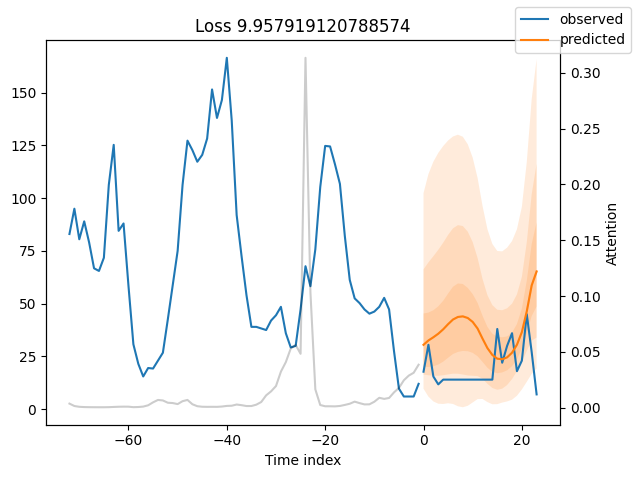

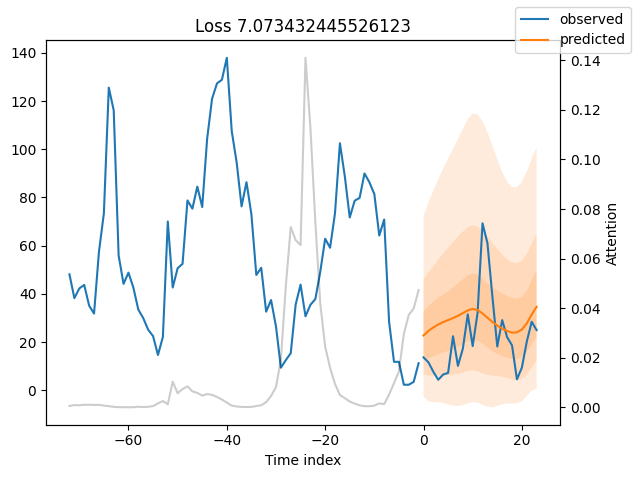

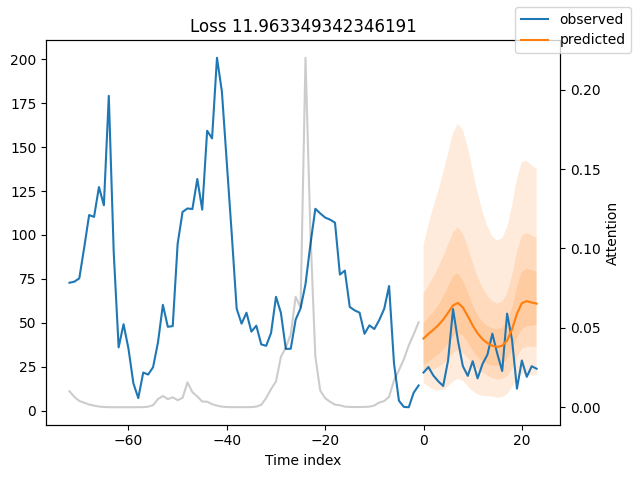

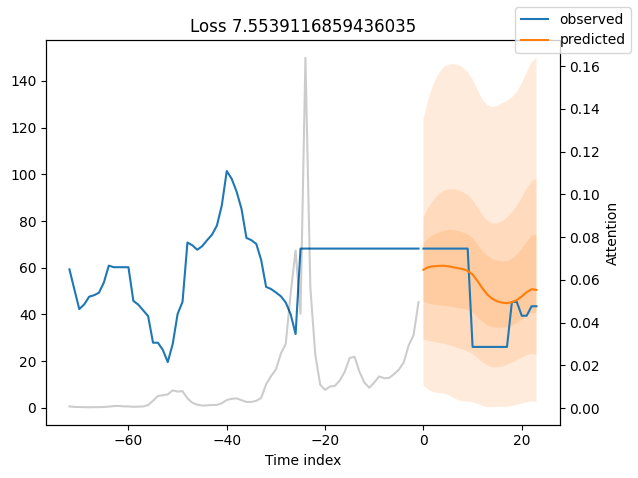

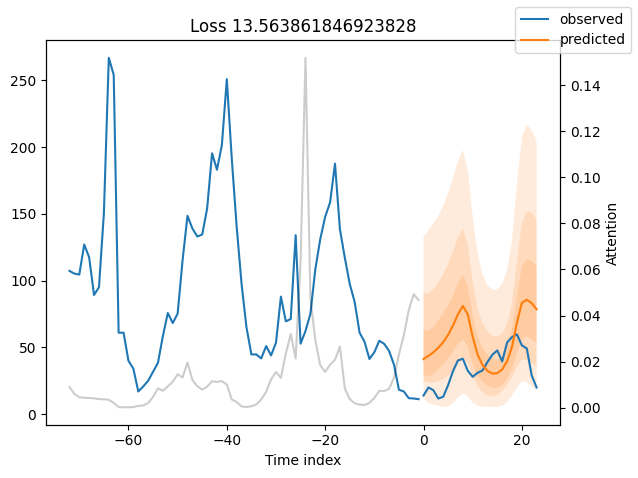

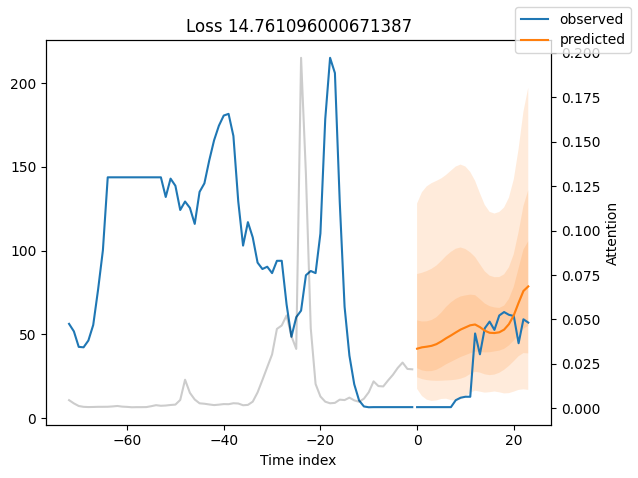

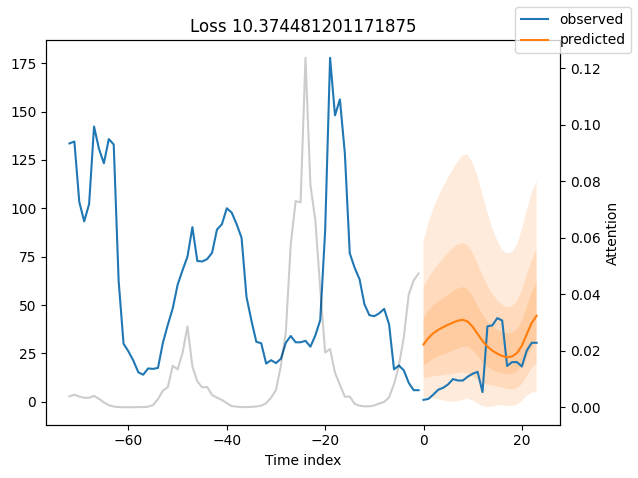

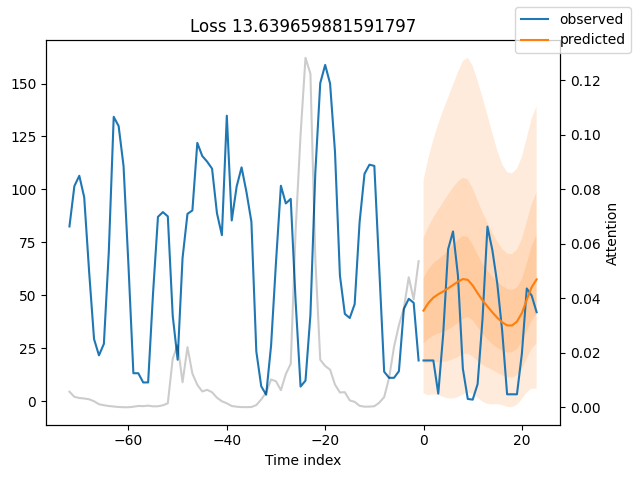

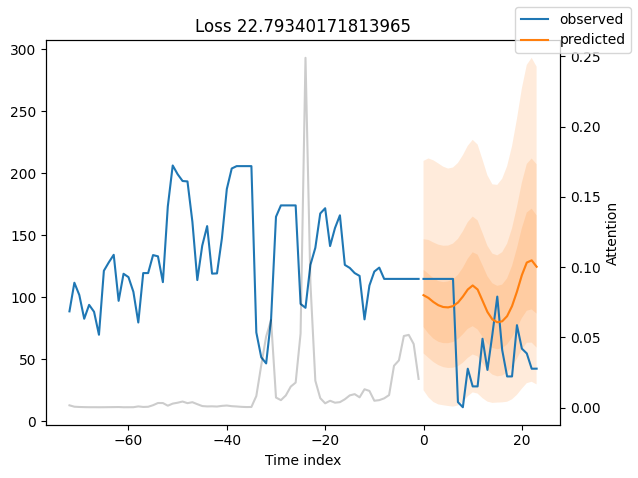

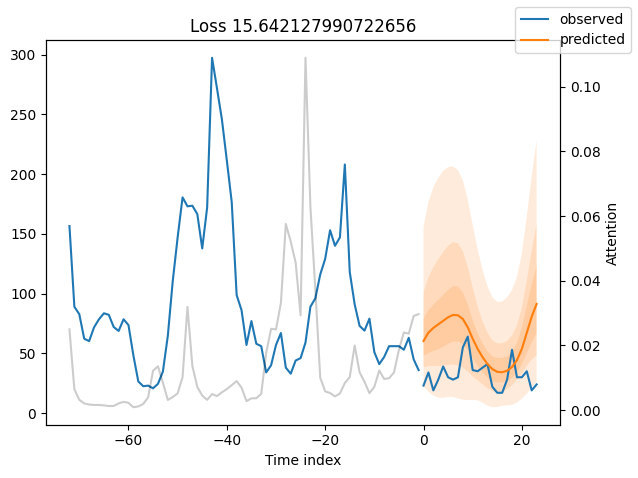

In [ ]:
for idx in range(min(10, batch_size)):  
    best_tft.plot_prediction(
        val_prediction_results.x, val_prediction_results.output, idx=idx, add_loss_to_title=True
    )

# Analyze Variable Importance

Interpret which features are most important for the model's predictions.

In [40]:
# Generate interpretation of the model
interpretation = best_tft.interpret_output(val_prediction_results.output, reduction="sum")

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x350 with 1 Axes>,
 'encoder_variables': <Figure size 700x1400 with 1 Axes>,
 'decoder_variables': <Figure size 700x475 with 1 Axes>}

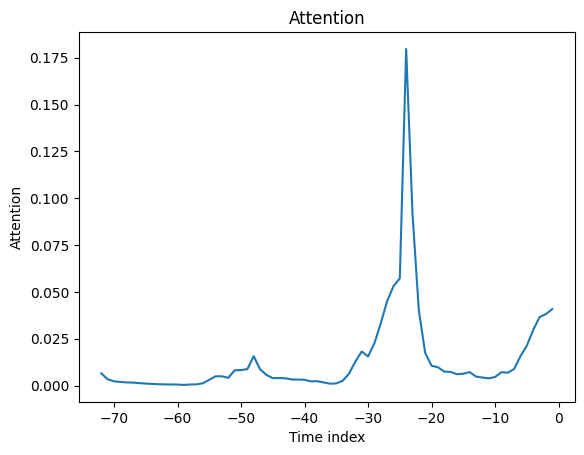

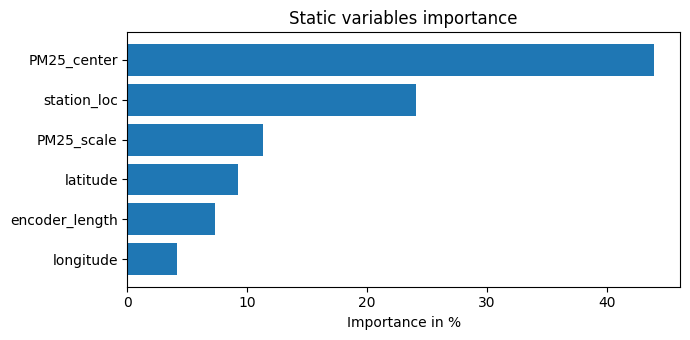

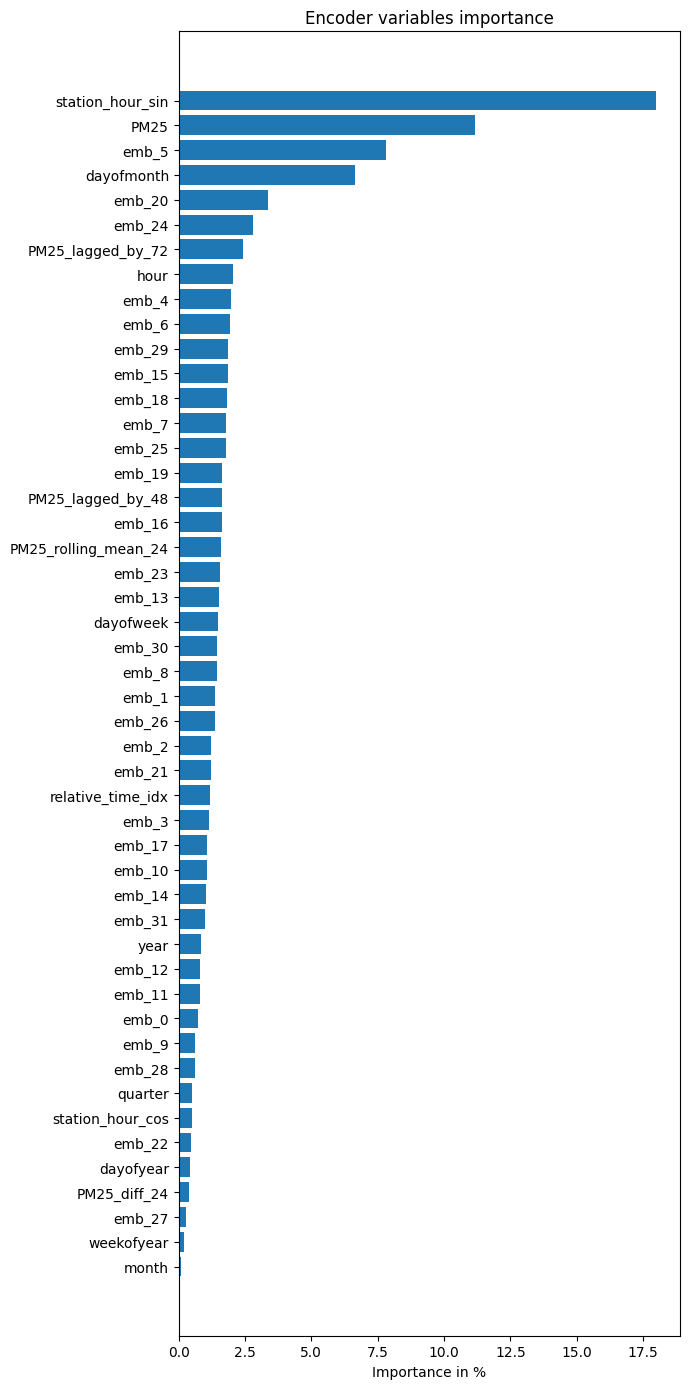

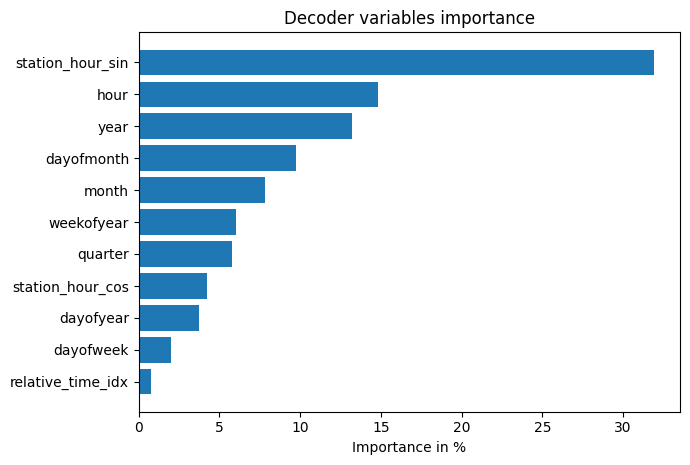

In [41]:
# Plot variable importance
best_tft.plot_interpretation(interpretation)

In [44]:
# # Plot attention patterns for a specific example
# best_tft.plot_attention(
#     val_prediction_results.x, val_prediction_results.output, 
#     idx=0, # First example in batch
#     attention="decoder_self"
# )

# Save Model

Save the trained model for future use.

In [ ]:
save_dir = "/code/GCNTFT/models/tft"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the trained model
model_path = f"{save_dir}/air_quality_tft_model_{pd.Timestamp.now().strftime('%Y%m%d_%H%M')}.ckpt"
trainer.save_checkpoint(model_path)
print(f"Model saved to: {model_path}")

Model saved to: /code/GCNTFT/models/tft/air_quality_tft_model_20250406_1749.ckpt


# Generate Future Predictions

Use the trained model to forecast future PM2.5 values.

In [61]:
last_data = air_quality_df.groupby('station_loc').apply(lambda x: x.iloc[-max_encoder_length:]).reset_index(drop=True)

/tmp/ipykernel_217943/90339887.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  last_data = air_quality_df.groupby('station_loc').apply(lambda x: x.iloc[-max_encoder_length:]).reset_index(drop=True)


In [71]:
# Create the validation dataset
pred_ds = TimeSeriesDataSet.from_dataset(
    training, 
    air_quality_df, 
    min_prediction_idx=training_cutoff + max_prediction_length+1,
    predict=True,
    stop_randomization=True,
)

In [72]:
# # Create prediction dataset
# pred_dataset = TimeSeriesDataSet(
#     data=last_data,
#     time_idx="time_idx",
#     target="PM25",
#     group_ids=["station_loc"],
#     max_encoder_length=max_encoder_length,
#     min_prediction_length=max_prediction_length,
#     max_prediction_length=max_prediction_length,
#     static_categoricals=["station_loc"],
#     static_reals=["latitude", "longitude"],
#     time_varying_known_categoricals=[],
#     time_varying_known_reals=time_varying_known_reals,
#     time_varying_unknown_categoricals=[],
#     time_varying_unknown_reals=time_varying_unknown_reals,
#     target_normalizer=GroupNormalizer(
#         groups=["station_loc"]
#     ),
#     lags={
#         "PM25": [48,72], #, 96, 120, 144, 168
#     },
#     add_relative_time_idx=True,
#     add_target_scales=True,
#     add_encoder_length=True,
# )


In [ ]:
pred_dataloader = pred_ds.to_dataloader(batch_size=32, train=False, shuffle=False)

In [74]:
# Generate predictions
future_predictions = best_tft.predict(pred_dataloader, return_x=True, mode="raw")
print(f"Generated forecasts for {len(future_predictions.output)} examples")

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/miniconda3/envs/gnns/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Generated forecasts for 8 examples


# Visualize Forecasts

Create plots of the forecasted PM2.5 values by station.

In [ ]:
# Create output directory for plots
output_dir = f"/code/GCNTFT/outputs/forecasts_{pd.Timestamp.now().strftime('%Y%m%d_%H%M')}"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
for idx in range(len(future_predictions.output)):
    fig = best_tft.plot_prediction(
        future_predictions.x, 
        future_predictions.output, 
        idx=idx, 
        add_loss_to_title=False,
        show_future_observed=False
    )
    
    station_name = future_predictions.x["groups"][idx].item()
    plt.title(f"PM2.5 Forecast for Station: {station_name}")
    
    plt.savefig(f"{output_dir}/forecast_station_{station_name}.png")
    plt.close()

print(f"Forecast visualizations saved to {output_dir}")

Forecast visualizations saved to /code/GCNTFT/outputs/forecasts_20250406_1832


In [ ]:
# Create summary dataframe of forecasts
station_ids = []
forecast_values = []

for idx in range(len(future_predictions.output)):
    station_name = future_predictions.x["groups"][idx].item()
    forecast = future_predictions.output[idx].float().mean(0).detach().cpu().numpy()
    
    station_ids.append(station_name)
    forecast_values.append(forecast)

forecasts_df = pd.DataFrame({
    'station': station_ids,
    'forecast_mean': [f.mean() for f in forecast_values],
    'forecast_max': [f.max() for f in forecast_values],
    'forecast_min': [f.min() for f in forecast_values]
})

forecasts_df.sort_values('forecast_mean', ascending=False)

,station,forecast_mean,forecast_max,forecast_min
7,7,72.000000,72.000000,72.000000
0,0,59.751900,172.346512,4.004886
6,6,24.000000,24.000000,24.000000
3,3,0.166667,0.439135,0.040989
5,5,0.090909,0.415464,0.007231
4,4,0.020833,0.360306,0.000633
1,1,0.013628,0.354974,0.000028
2,2,0.000783,0.013533,0.000000


In [ ]:
forecasts_df.to_csv(f"{output_dir}/forecast_summary.csv", index=False)
print("Forecast summary saved successfully.")

Forecast summary saved successfully.
